## Library

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from einops import rearrange
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from tqdm import tqdm_notebook as tqdm

from collections import OrderedDict
import torch.distributed as dist
import logging
from PIL import Image
from jpdvt import DiT_models, get_2d_sincos_pos_embed
from copy import deepcopy
from jpdvt_diffusion import create_diffusion
from sklearn.metrics import pairwise_distances
import os, sys
sys.path.append('/home/sjsong/Dropbox/GR/notebook_files/util')
from tester import visualLoss

gpu_ids = []
device_names = []
if torch.cuda.is_available():
    for gpu_id in range(torch.cuda.device_count()):
        gpu_ids += [gpu_id]
        device_names += [torch.cuda.get_device_name(gpu_id)]
print(gpu_ids)
print(device_names)

if len(gpu_ids) > 1:
    gpu = 'cuda:' + str(gpu_ids[2])  # GPU Number
else:
    gpu = "cuda" if torch.cuda.is_available() else "cpu"

[0, 1, 2, 3]
['TITAN Xp', 'TITAN Xp', 'TITAN Xp', 'TITAN Xp']


## Hyper parameter

In [2]:
device = gpu
LEARNING_RATE = 7e-05  # 1e-04
BATCH_SIZE = 32  # 96
NUM_EPOCHS = 200  # 500
NUM_WORKERS = 2
TASK_NAME = 'puzzle_cifar10'
MODEL_NAME = 'jpdvt'
pre_load_model_path = './save/xxx.pt'
pre_model_path = f'./save/{TASK_NAME}_{MODEL_NAME}_ep{NUM_EPOCHS}_lr{LEARNING_RATE}_b{BATCH_SIZE}.pt'

## Dataset

In [3]:
INPUT_SIZE = 225
AFTER_CROP_SIZE = 192
transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataset = Subset(train_dataset, list(range(int(0.2 * len(train_dataset)))))
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified


## Pre-training class

In [6]:
class PreTrainer(object):
    def __init__(self):
        self.model = None
        self.optimizer = None
        self.ema = None
        self.epochs = []
        self.losses = []
        self.accuracies = []
        self.accuracies_puzzle = []

    def process(self, load=False, reload=False):
        self.build_model(load)
        self.pretrain_model(reload)
        self.save_model()

    def build_model(self, load):
        self.model = DiT_models['JPDVT'](input_size=AFTER_CROP_SIZE).to(device)
        print(f'Parameter: {sum(p.numel() for p in self.model.parameters() if p.requires_grad)}')
        if load:
            checkpoint = torch.load(pre_load_model_path)
            self.epochs = checkpoint['epochs']
            self.model.load_state_dict(checkpoint['model'])
            self.losses = checkpoint['losses']
            print(f'Parameter: {sum(p.numel() for p in self.model.parameters() if p.requires_grad)}')
            print(f'Epoch: {self.epochs[-1]}')
            print(f'****** Reset epochs and losses ******')
            self.epochs = []
            self.losses = []

    def pretrain_model(self, reload):
        self.ema = deepcopy(self.model).to(device)
        requires_grad(self.ema, False)
        diffusion = create_diffusion(timestep_respacing="")
        update_ema(self.ema, self.model, decay=0)
        model = self.model.train()
        ema = self.ema.eval()

        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0)
        range_epochs = range(NUM_EPOCHS)

        for epoch in range_epochs:
            print(f"epoch {epoch + 1} learning rate : {optimizer.param_groups[0]['lr']}")
            running_loss = 0.
            for batch_idx, (x, _) in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
                x = x.to(device)
                centercrop = transforms.CenterCrop((64, 64))
                patchs = rearrange(x, 'b c (p1 h1) (p2 w1)-> b c (p1 p2) h1 w1', p1=3, p2=3, h1=INPUT_SIZE//3, w1=INPUT_SIZE//3)
                patchs = centercrop(patchs)
                x = rearrange(patchs, 'b c (p1 p2) h1 w1-> b c (p1 h1) (p2 w1)', p1=3, p2=3, h1=AFTER_CROP_SIZE // 3, w1=AFTER_CROP_SIZE // 3)

                time_emb = torch.tensor(get_2d_sincos_pos_embed(8, 3)).unsqueeze(0).float().to(device)

                t = torch.randint(0, diffusion.num_timesteps, (x.shape[0],), device=device)
                model_kwargs = None
                loss_dict = diffusion.training_losses(model, x, t, time_emb, model_kwargs,
                                                      block_size=AFTER_CROP_SIZE // 3, patch_size=16,
                                                      add_mask=False)
                loss = loss_dict["loss"].mean()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                update_ema(ema, model)
                running_loss += loss.item()

                inter = 100
                if batch_idx % inter == inter - 1:
                    print(f'[Epoch {epoch + 1}] [Batch {batch_idx + 1}] Loss: {running_loss / inter:.4f}')
                    self.epochs.append(epoch + 1)
                    self.losses.append(running_loss / inter)
                    running_loss = 0.
            self.model = model
            self.optimizer = optimizer
            self.save_model()
            visualLoss(self.losses)
            self.val_model(epoch)
        print('****** Finished Fine-tuning ******')
        self.model = model

    def val_model(self, epoch=-1):
        model = self.model.train()

        diffusion = create_diffusion('1000')
        time_emb = torch.tensor(get_2d_sincos_pos_embed(8, 3)).unsqueeze(0).float().to(device)
        time_emb = time_emb.repeat(BATCH_SIZE, 1, 1)
        time_emb_noise = torch.tensor(get_2d_sincos_pos_embed(8, 12)).unsqueeze(0).float().to(device)
        time_emb_noise = time_emb_noise.repeat(BATCH_SIZE, 1, 1)
        time_emb_noise = torch.randn_like(time_emb_noise)
        model_kwargs = None

        abs_results = []
        frag_results = []
        with torch.no_grad():
            for batch_idx, (x, _) in tqdm(enumerate(val_loader, 0), total=len(val_loader)):
                x = x.to(device)
                x_crop = torch.zeros(BATCH_SIZE, 3, 192, 192).to(device)
                for idx, x_ in enumerate(x):
                    centercrop = transforms.CenterCrop((64, 64))
                    patchs = rearrange(x_, 'c (p1 h1) (p2 w1)-> c (p1 p2) h1 w1', p1=3, p2=3, h1=INPUT_SIZE//3, w1=INPUT_SIZE//3)
                    patchs = centercrop(patchs)
                    x_ = rearrange(patchs, 'c (p1 p2) h1 w1-> c (p1 h1) (p2 w1)', p1=3, p2=3, h1=AFTER_CROP_SIZE // 3, w1=AFTER_CROP_SIZE // 3)

                    indices = np.random.permutation(9)
                    x_ = rearrange(x_, 'c (p1 h1) (p2 w1)-> c (p1 p2) h1 w1', p1=3, p2=3, h1=AFTER_CROP_SIZE // 3, w1=AFTER_CROP_SIZE // 3)
                    x_ = x_[:, indices, :, :]
                    x_ = rearrange(x_, 'c (p1 p2) h1 w1-> c (p1 h1) (p2 w1)', p1=3, p2=3, h1=AFTER_CROP_SIZE // 3, w1=AFTER_CROP_SIZE // 3)
                    x_crop[idx] = x_
                x = x_crop
                
                samples = diffusion.p_sample_loop(
                    model.forward, x, time_emb_noise.shape, time_emb_noise, clip_denoised=False,
                    model_kwargs=model_kwargs, progress=True, device=device
                )
                for sample, img in zip(samples, x):
                    sample = rearrange(sample, '(p1 h1 p2 w1) d-> (p1 p2) (h1 w1) d', p1=3, p2=3, h1=AFTER_CROP_SIZE // 48, w1=AFTER_CROP_SIZE // 48)
                    sample = sample.mean(1)
                    dist = pairwise_distances(sample.cpu().numpy(), time_emb[0].cpu().numpy(), metric='manhattan')
                    order = find_permutation(dist)
                    pred = np.asarray(order).argsort()
                    abs_results.append(int((pred == indices).all()))
                    frag_results.append(np.sum(pred == indices))

        puzzle_acc = 100 * np.asarray(abs_results).sum() / len(abs_results)
        frag_acc = 100 * np.sum(frag_results) / (len(frag_results) * len(indices))
        print(f'[Epoch {epoch + 1}] Accuracy (Puzzle-level) on the test set: {puzzle_acc:.2f}%')
        print(f'[Epoch {epoch + 1}] Accuracy (Fragment-level) on the test set: {frag_acc:.2f}%')
        self.accuracies.append(frag_acc)
        self.accuracies_puzzle.append(puzzle_acc)

    def save_model(self):
        checkpoint = {
            'epochs': self.epochs,
            'model': self.model.state_dict(),
            'ema': self.ema.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'losses': self.losses,
            'accuracies': self.accuracies,
            'accuracies_puzzle': self.accuracies_puzzle,
        }
        torch.save(checkpoint, pre_model_path)
        # if self.epochs[-1] % 50 == 0:
        #     torch.save(checkpoint, pre_model_path[:-3]+f'_{self.epochs[-1]}l{NUM_EPOCHS}.pt')
        print(f"****** Model checkpoint saved at epochs {self.epochs[-1]} ******")


@torch.no_grad()
def update_ema(ema_model, model, decay=0.9999):
    """
    Step the EMA model towards the current model.
    """
    ema_params = OrderedDict(ema_model.named_parameters())
    model_params = OrderedDict(model.named_parameters())

    for name, param in model_params.items():
        # TODO: Consider applying only to params that require_grad to avoid small numerical changes of pos_embed
        ema_params[name].mul_(decay).add_(param.data, alpha=1 - decay)


def requires_grad(model, flag=True):
    """
    Set requires_grad flag for all parameters in a model.
    """
    for p in model.parameters():
        p.requires_grad = flag


def cleanup():
    """
    End DDP training.
    """
    dist.destroy_process_group()


def create_logger(logging_dir):
    """
    Create a logger that writes to a log file and stdout.
    """
    if dist.get_rank() == 0:  # real logger
        logging.basicConfig(
            level=logging.INFO,
            format='[\033[34m%(asctime)s\033[0m] %(message)s',
            datefmt='%Y-%m-%d %H:%M:%S',
            handlers=[logging.StreamHandler(), logging.FileHandler(f"{logging_dir}/log.txt")]
        )
        logger = logging.getLogger(__name__)
    else:  # dummy logger (does nothing)
        logger = logging.getLogger(__name__)
        logger.addHandler(logging.NullHandler())
    return logger


def center_crop_arr(pil_image, image_size):
    """
    Center cropping implementation from ADM.
    https://github.com/openai/guided-diffusion/blob/8fb3ad9197f16bbc40620447b2742e13458d2831/guided_diffusion/image_datasets.py#L126
    """
    while min(*pil_image.size) >= 2 * image_size:
        pil_image = pil_image.resize(
            tuple(x // 2 for x in pil_image.size), resample=Image.BOX
        )

    scale = image_size / min(*pil_image.size)
    pil_image = pil_image.resize(
        tuple(round(x * scale) for x in pil_image.size), resample=Image.BICUBIC
    )

    arr = np.array(pil_image)
    crop_y = (arr.shape[0] - image_size) // 2
    crop_x = (arr.shape[1] - image_size) // 2
    return Image.fromarray(arr[crop_y: crop_y + image_size, crop_x: crop_x + image_size])


def find_permutation(distance_matrix):
    sort_list = []
    for m in range(distance_matrix.shape[1]):
        order = distance_matrix[:, 0].argmin()
        sort_list.append(order)
        distance_matrix = distance_matrix[:, 1:]
        distance_matrix[order, :] = 2024
    return sort_list

Parameter: 130747208
epoch 1 learning rate : 1e-05


/tmp/ipykernel_373104/3147777988.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (x, _) in tqdm(enumerate(train_loader, 0), total=len(train_loader)):


  0%|          | 0/6250 [00:00<?, ?it/s]

[Epoch 1] [Batch 2] Loss: 0.4991
****** Model checkpoint saved at epochs 1 ******


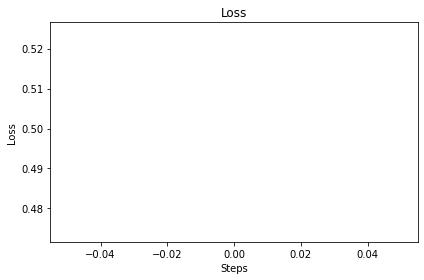

/tmp/ipykernel_373104/3147777988.py:94: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (x, _) in tqdm(enumerate(val_loader, 0), total=len(val_loader)):


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[0, 0, 0, 0, 0, 0, 0, 0]
[2, 1, 1, 1, 1, 2, 3, 0]


  0%|          | 0/1000 [00:00<?, ?it/s]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 1, 1, 1, 1, 2, 3, 0, 0, 1, 2, 2, 1, 0, 1, 0]


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
if __name__ == '__main__':
    trainer = PreTrainer()
    trainer.process(load=False)

In [ ]:
'''

ㅇㅁㅇ

'''